In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1
# Усложненная
### Эта домашка нужна для лучшего понимания, но она будет сложнее из-за использования классов и, возможно, пока непривычной форме с классами.
Абстракции в этой домашке будут очень полезны для понимания того, что происходит в торче. Эта домашка прокачает вас гораздо сильнее, но и выполнить ее будет труднее. Вам нужно будет описать несколько слоев: `Linear`, `ReLU`, `BCELoss`.  Реализация `Sigmoid` уже есть в `our_library.layers`. Реализовав слои выше вы сможете сделать n-слойную нейронную сеть с любым количеством слоев. Это получается за счет того, что вы описали всю необходимую логику:
- Как нужно обработать входные данные и передать их дальше;
- Принять градиент с последующего слоя, сделать `backward` для текущего слоя и передать градиент предыдущему слою;
- Как обновить веса, если в слоев есть обучаемые веса.

Присылайте свои недоделанные сложные домашки, пусть они не пойдут совсем в стол. Я или ассистенты посмотрят, мы обсудим и доделаем.  
Поверьте, эта домашка стоит того, чтобы ее сделать!

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

Epoch 1:   0%|                                           | 0/97 [03:17<?, ?it/s]


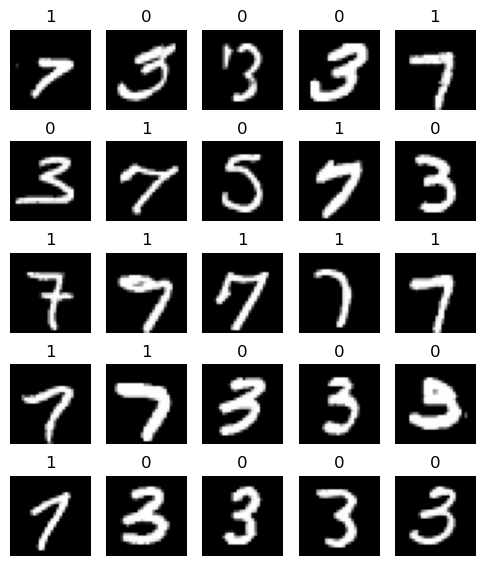

In [178]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [179]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [180]:
x.shape

torch.Size([128, 1, 28, 28])

In [181]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [10]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [11]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [12]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [13]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [14]:
y

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

# Итерация по эпохам

In [15]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация
        
        time.sleep(0.01)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [16]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.657028  , 0.71452723, 0.42847251, ..., 0.80339731, 0.31967617,
        0.21209856],
       [0.46852794, 0.04752338, 0.82049434, ..., 0.20630552, 0.07144244,
        0.96085239],
       [0.07140956, 0.9762506 , 0.17528196, ..., 0.1173202 , 0.71982181,
        0.66174219],
       ...,
       [0.84504517, 0.89113389, 0.44374286, ..., 0.25443148, 0.38922185,
        0.42415458],
       [0.95390223, 0.72144218, 0.39543241, ..., 0.11608673, 0.07087737,
        0.51312354],
       [0.43641951, 0.33203231, 0.5410906 , ..., 0.11816261, 0.3571409 ,
        0.21000658]])

In [17]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы 
x ** 2 + np.log(x)

array([[ 0.01165716,  0.174415  , -0.66394   , ...,  0.42654132,
        -1.03825391, -1.5057184 ],
       [-0.53864111, -3.0442749 ,  0.4753627 , ..., -1.53583512,
        -2.63375922,  0.88330284],
       [-2.63422427,  0.92902926, -1.71063566, ..., -2.12908433,
         0.18939186,  0.02502348],
       ...,
       [ 0.54573614,  0.67885901, -0.6156023 , ..., -1.30398833,
        -0.79211213, -0.67775021],
       [ 0.86273536,  0.19397578, -0.77140861, ..., -2.13994153,
        -2.64178044, -0.40394289],
       [-0.63868932, -0.99227754, -0.32138952, ..., -2.12173114,
        -0.90207526, -1.51651365]])

In [18]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [19]:
res

array([[135.62094066, 132.21667068, 134.05865929, ..., 133.83877382,
        136.38408341, 130.92867661],
       [131.17389946, 128.13700424, 131.9706724 , ..., 129.79690457,
        131.51512184, 122.70953415],
       [127.22161557, 124.18714593, 130.97534592, ..., 127.30300851,
        124.81207398, 120.42573362],
       ...,
       [133.99886001, 129.05453637, 131.55911756, ..., 132.65766252,
        133.36260427, 124.2882181 ],
       [128.55243542, 123.37342166, 130.62829267, ..., 130.57213979,
        127.66444367, 119.12121732],
       [128.91983641, 125.75906341, 128.76728162, ..., 129.92164449,
        127.06152937, 121.12427615]])

In [20]:
res.shape == (x.shape[0], y.shape[1])

True

# Импортируем нашу библиотеку
В ней реализованы некоторые полезные методы, в модуле `layers` есть реализация сигмоиды. Остальное вам смотреть необязательно, это некоторые дополнения, упрощающие вам жизнь.

In [21]:
from our_library import layers, wrapper, tools

## Реализуйте слои:
- Linear - линейная трансформация (не забудьте, что у нас в этом слое как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, 1)

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом) для примера

# Пример c сигмоидой
В `our_library.layers` также это есть

In [22]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass

# Тестирование

In [249]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [250]:
sigmoid_layer = Sigmoid()
forward_result = sigmoid_layer.forward(x)
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [251]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [252]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward_result)

# Линейный слой

In [253]:
class Linear:

    def __init__(self, in_features, out_features):
        # инициализируем веса
        self.weight = torch.nn.Parameter(torch.rand(in_features, out_features) * 0.01)
        self.bias = torch.nn.Parameter(torch.zeros(out_features))
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None

    def forward(self, x):
        self.x = x
        return np.dot(x,self.weight) + self.bias

    def backward(self, grad):
        #градиент для весов и смещений
        self._grad_weight = np.dot(self.x.T, grad)
        self._grad_bias = np.sum(grad, axis=0)
        return np.dot(grad, self.weight.T)

    def step(self, learning_rate):
        #обновляем веса и смещение
        self.weight -= learning_rate * self._grad_weight
        self.bias -= learning_rate * self._grad_bias

In [254]:
# class Linear:

#     def __init__(self, in_features, out_features):
#         # инициализируем веса
#         self.weight = torch.nn.Parameter(torch.rand(in_features, out_features) * 0.01)
#         self.bias = torch.nn.Parameter(torch.zeros(out_features))
        
#         # сохраняем градиент для весов
#         self._grad_weight = None
#         self._grad_bias = None

#     def forward(self, x):
#         if isinstance(x, np.ndarray):
#             x = torch.tensor(x, dtype=torch.float32)
#         self.x = x
#         return x @ self.weight + self.bias

#     def backward(self, grad):
#         #градиент для весов и смещений
#         self._grad_weight = np.dot(self.x.T, grad)
#         self._grad_bias = np.sum(grad, axis=0)
#         return grad @ self.weight.T

#     def step(self, learning_rate):
#         #обновляем веса и смещение
#         self.weight -= learning_rate * self._grad_weight
#         self.bias -= learning_rate * self._grad_bias

# Тестирование

In [255]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [256]:
linear = Linear(in_features=4, out_features=3)

In [257]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [258]:
forward = linear.forward(x)
backward = linear.backward(previous_grad)

In [259]:
#значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [260]:
assert np.allclose(correct_backward_result, backward)

In [261]:
assert np.allclose(linear._grad_weight, correct_grad_weight)

In [262]:
assert np.allclose(linear._grad_bias, correct_grad_bias)

# ReLU

In [263]:
class ReLU:

    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, prev_grad):
        # 1 там, где x > 0, иначе 0
        relu_grad = (self.x > 0).astype(float)
        # передаем дальше
        return prev_grad * relu_grad

    def step(self, learning_rate):
        #если я правильно поняла, здесь ничего не должно быть..
        pass

# Тестирование

In [264]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [265]:
relu = ReLU()

In [266]:
forward = relu.forward(x)
backward = relu.backward(previous_grad)

In [267]:
assert np.allclose(correct_forward_result, forward)

In [268]:
assert np.allclose(correct_backward_result, backward)

# BCE test

### Не забудьте добавить np.expand_dims(y, 1) в forward

In [269]:
class BCELoss:

    def __init__(self):
        #инпут
        self.x = None
        #таргет (истинные значения)
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = np.expand_dims(y, 1)

        epsilon = 1e-12  # нагуглила, что при вычислении логарифмов полезно добавлять небольшое значение для численной стабильности
        loss = -np.mean(self.y * np.log(x + epsilon) + (1 - self.y) * np.log(1 - x + epsilon))
        return loss

    def backward(self):
        epsilon = 1e-12
        grad = -(self.y / (self.x + epsilon)) + ((1 - self.y) / (1 - self.x + epsilon))
        grad /= self.x.shape[0]  # усредняем по количеству примеров в батче
        return grad

    def step(self, learning_rate):
        pass

# Тестирование

In [270]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

correct_forward_result = 0.24384403491500606

correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [271]:
loss = BCELoss()

In [272]:
forward = loss.forward(x, y)
backward = loss.backward()

In [273]:
assert np.allclose(correct_forward_result, forward)

In [274]:
assert np.allclose(correct_backward_result, backward)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: обновление весов можно сделать циклом
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward, то есть последний слой нашей сети
- TIP 5: forward и backward ничего не должны отдавать, в них должны быть расчитаны градиенты для каждого слоя
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [275]:
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules

    def forward(self, x):
        for module in self.modules:
            x = module.forward(x)
            
    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        for module in self.modules[::-1]:
            grad = module.backward(grad)

    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate)

## Реализуйте обертку над моделью

In [276]:
class MNISTWrapper(wrapper.Wrapper):
    def __init__(self, model, loss, learning_rate):
        self.model = model
        self.loss = loss
        self.learning_rate = learning_rate
        self.verbose = True
        
    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
    
        self.model.forward(x)
        loss_batch = self.loss.forward(self.model.modules[-1].input, y)
        grad_loss = self.loss.backward()


        self.model.backward(grad_loss)
        self.model.step(self.learning_rate)
        predictions = self.model.modules[-1].x
        return loss_batch, predictions

In [277]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 10

# задайте слои в свою нейронную сеть, например, 3 слоя
sloi = [
    Linear(in_features=784, out_features=128),
    ReLU(),
    Linear(in_features=128, out_features=64),
    ReLU(),
    Linear(in_features=64, out_features=1)
]
# sloi = [
#     Linear(in_features=128, out_features=64),
#     ReLU(),
#     Linear(in_features=64, out_features=1)
# ]
neural_network = NeuralNetwork(modules=sloi)

loss = BCELoss()

In [278]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

## Обучение модели

In [279]:
classifier.train(train_loader, test_loader, epochs=epochs)




Epoch 1:   0%|                                           | 0/97 [00:00<?, ?it/s]

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

AttributeError: 'MNISTWrapper' object has no attribute 'losses'

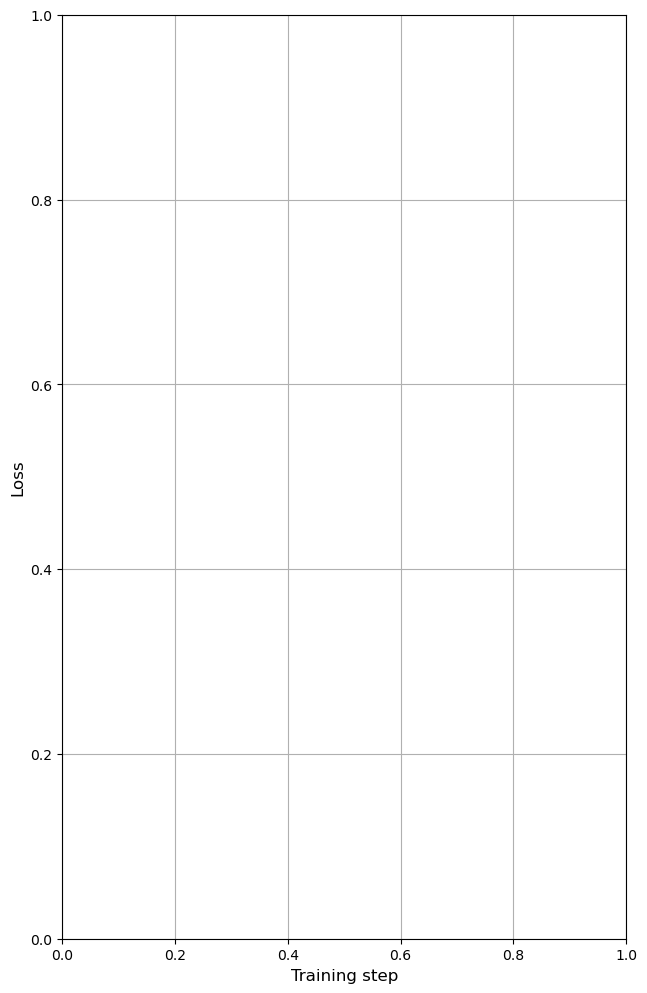

In [173]:
classifier.plot()